## Plot results of training of a SVDTime Neural Network

This notebook displays the results of time fits for digit produced by the SVD digitizer.
The digits are collected using the SVDFitDigitsModule, and its output is imported and shown here. 

##### Required Python packages

The following python packages are used:
- math (basic python math functions)
- numpy (Vectors and matrices for numerics)
- pandas (Python analogue of Excel tables)
- matplotlib (Plotting library)
- seaborn (Advanced plotting)
- scipy (Scientific computing package)
- scikit-learn (machine learning)

If you get an error message complaining about a missing package, do

pip3 install *_package name_*

##### Other pre-requisites:

A sample of training data, plus binning and bounds information in pickle (*.pkl) files.

In [1]:
import math
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
from scipy import stats as stats
from scipy.optimize import minimize_scalar
from SVDSimBase import *

### Retrieve dumped digit fits

In [2]:
digit_fit_filename = '../../SVDFittedDigits.txt'

fitdata = pd.read_csv(digit_fit_filename, sep = '\t')

pkl_name = 'SVDTime_TrainingBins_1000000.pkl'
bins = pd.read_pickle(pkl_name)

timearray = bins['midpoint']
timebins = np.unique(bins[['lower','upper']])

In [3]:
fitdata.head()

,Layer,Ladder,Sensor,Side,Strip,Sample_0,Sample_1,Sample_2,Sample_3,Sample_4,...,P_20,P_21,P_22,P_23,P_24,TimeFit,TimeFitError,Amplitude,AmplitudeError,Chi2
0,3,5,2,u,700,0,0,17,35,34,...,0.000000,0.000000,0.000000,0.0,0.0,9.228710,2.72314,35.2797,1.33071,0.835786
1,3,5,2,u,701,0,0,12,29,28,...,0.000000,0.000000,0.000000,0.0,0.0,13.946300,2.85902,30.9229,1.34890,0.870517
2,3,5,2,v,567,0,0,12,50,67,...,0.497162,0.316527,0.180457,0.0,0.0,27.887500,3.87522,69.0723,1.39942,4.239370
3,4,8,2,u,427,0,0,20,25,24,...,0.000000,0.000000,0.000000,0.0,0.0,0.479326,3.21901,27.0457,1.05937,1.124310
4,4,8,2,u,428,0,0,11,35,33,...,0.000105,0.000000,0.000000,0.0,0.0,14.411200,1.92607,34.7240,1.09744,1.224450


In [4]:
fitdata.columns

Index(['Layer', 'Ladder', 'Sensor', 'Side', 'Strip', 'Sample_0', 'Sample_1',
       'Sample_2', 'Sample_3', 'Sample_4', 'Sample_5', 'TrueTime', 'P_0',
       'P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'P_6', 'P_7', 'P_8', 'P_9', 'P_10',
       'P_11', 'P_12', 'P_13', 'P_14', 'P_15', 'P_16', 'P_17', 'P_18', 'P_19',
       'P_20', 'P_21', 'P_22', 'P_23', 'P_24', 'TimeFit', 'TimeFitError',
       'Amplitude', 'AmplitudeError', 'Chi2'],
      dtype='object')

Load the classifier

In [5]:
import pickle
with open('classifier.pkl', 'rb') as f:
    classifier = pickle.load(f)
    
# the sample size of the network we want to use
n_samples = 1000000
pkl_name = 'SVDTime_Training{0}_{1}.pkl'

bounds = pd.read_pickle(pkl_name.format('Bounds', n_samples))

amp_range = (
    bounds.loc[bounds.value == 'amplitude','low'].values[0],
    bounds.loc[bounds.value == 'amplitude','high'].values[0]
)
tau_range =(
    bounds.loc[bounds.value == 'tau','low'].values[0],
    bounds.loc[bounds.value == 'tau','high'].values[0]
)
coder = tau_encoder(amp_range, tau_range)
coder.encode(250)


41.468087719625657

### Now that we have the time shifts and amplitudes, do some plotting.

We want to know the errors and biases of time shifts and amplitudes provided by the network.
We use two kind of plots - simple 2d histograms and contour plots. Both have their advantages and disadvantages. 

<function __main__.plot_data>

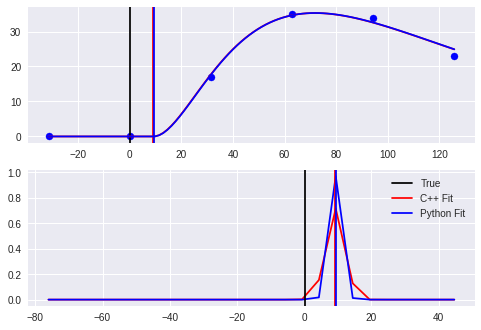

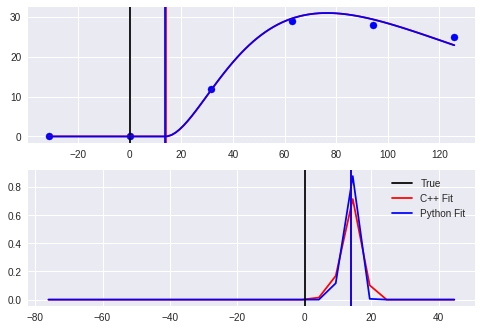

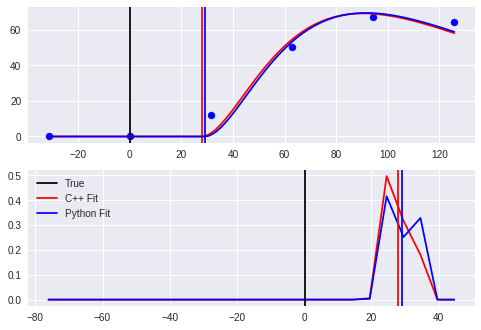

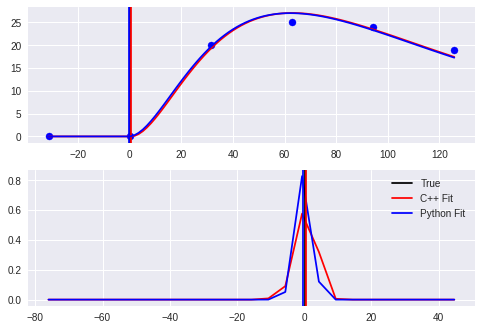

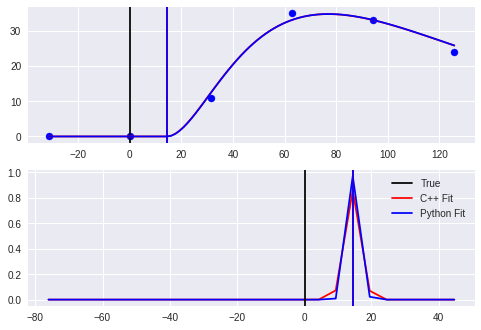

In [6]:
from ipywidgets import *

def fitFromProb(fw, signals, p, tau, timearray):
    t_fit = np.average(timearray, weights = p)
    t_sigma = np.sqrt(np.average((timearray - t_fit)**2, weights = p))
    weights = fw(-t_fit + np.linspace(-dt, 4*dt, 6, endpoint = True), tau = tau)
    weights[signals.values == 0.0] = 0.0
    norm = 1.0 / np.inner(weights, weights)
    a_fit = np.inner(signals, weights) * norm
    a_sigma = np.sqrt(norm)
    residuals = signals - a_fit * weights
    ndf = np.sum(np.ones_like(signals[signals>0])) - 2 # Can't be less than 1
    chi2_ndf = np.inner(residuals, residuals)/ndf
    return pd.Series({
        't_fit':t_fit, 
        't_sigma':t_sigma, 
        'a_fit':a_fit, 
        'a_sigma':a_sigma,
        'chi2_ndf':chi2_ndf
            })

def plot_data(irow):
    '''
    Given row number, plot signals, true waveform and fitted waveform, and plot probabilities.
    '''
    fig, axarr = plt.subplots(2, 1, sharex=False, sharey = False)
    # The first plot is data
    sample_times = np.linspace(-dt, 4*dt, 6, endpoint = True)
    function_times = np.linspace(-dt, 4*dt, 100, endpoint = True)
    samples = fitdata.loc[int(irow), ['Sample_{0}'.format(i) for i in range(6)]]
    tau_fit = 250
    # Let us fit using the python classifier
    x = np.zeros(7)
    x[0:6] = samples
    x[6] = coder.encode(tau_fit)
    x.reshape(1,-1)
    p_py = classifier.predict_proba(x)
    pyfit_result = fitFromProb(betaprime_wave, samples, p_py[0], tau_fit, timearray)
    a_fitPy = pyfit_result['a_fit']
    t_fitPy = pyfit_result['t_fit']
    a_fit = fitdata.loc[int(irow), 'Amplitude']
    t_fit = fitdata.loc[int(irow), 'TimeFit']
    t_true = fitdata.loc[int(irow), 'TrueTime']
    
    axarr[0].scatter(sample_times,samples, c = 'b', marker = 'o', s=50, label = 'Data')
    axarr[0].axvline(x = t_true, c = 'k', label = 'True')
    axarr[0].plot(function_times, a_fit * betaprime_wave(function_times - t_fit, tau = tau_fit), 
                  c = 'r', label = 'Fit')
    axarr[0].axvline(x = t_fit, c = 'r', label = 'C++ Fit')
    axarr[0].plot(function_times, a_fitPy * betaprime_wave(function_times - t_fitPy, tau = tau_fit), 
                  c = 'b', label = 'Fit')
    axarr[0].axvline(x = t_fitPy, c = 'b', label = 'Python Fit')
    # The second plot is probability density
    p = fitdata.loc[int(irow), ['P_{0}'.format(i) for i in range(len(timearray))]].values
    axarr[1].plot(timearray, p, c = 'r')
    axarr[1].plot(timearray, p_py[0], c='b')
    axarr[1].axvline(x = t_true, c = 'k', label = 'True')
    axarr[1].axvline(x = t_fit, c = 'r', label = 'C++ Fit')
    axarr[1].axvline(x = t_fitPy, c= 'b', label = 'Python Fit')
    plt.legend()
    #plt.show()
    #plt.savefig(image_dir + 'fit.png')
    print(fitdata.loc[int(irow),:])
    
interact(plot_data, irow = [int(x) for x in fitdata.index[:10]])

In [7]:
netinput = np.zeros(7)
netinput[0:6] = [0.0, 0.0, 4.6199, 18.4796, 26.5644, 22.522]
netinput[6] = coder.encode(250)
#netinput = netinput.reshape(-1,1)0 0 4.6199 18.4796 26.5644 22.5220 0 4.6199 18.4796 26.5644 22.522 
netinput

array([  0.        ,   0.        ,   4.6199    ,  18.4796    ,
        26.5644    ,  22.522     ,  41.46808772])

In [8]:
np.shape(classifier.coefs_[0])

(7, 24)

In [9]:
state = netinput
for i in range(3):
    state = np.clip(np.dot(state, classifier.coefs_[i]) + classifier.intercepts_[i], 0.0, 1.0e6)
    print(i, state.shape)
    print(classifier.coefs_[i])
    print(classifier.intercepts_[i])
    print(state)

0 (24,)
[[ -7.65828032e-002  -5.08503597e-002  -7.68014481e-001   4.06633072e-317
    3.77210277e-316   8.10882710e-001  -2.61839124e-001  -5.95168542e-001
    2.11539666e-316  -1.33116305e-317   6.66680338e-001  -8.76360330e-002
    6.82998013e-002   1.26599287e-001  -6.94619019e-001   5.05811125e-001
   -6.22605070e-002   4.18607441e-001  -2.39166111e-001  -4.83975084e-001
    1.28072964e-001   1.84044910e-001   8.49552927e-001  -6.88465933e-001]
 [  6.32060416e-001   1.10793902e-001  -4.55014147e-001   2.85682096e-317
   -8.23277989e-317   5.14777770e-001  -1.59036661e-001   3.54800090e-001
   -5.67582318e-317  -6.87733944e-318  -5.36183574e-001  -4.87559514e-001
    6.89092667e-001  -1.10207213e+000   8.49475940e-001  -2.91680311e-001
    1.54726110e-001   3.10906639e-001   2.92909472e-001  -8.38183022e-001
   -2.38129440e-001   5.29523650e-001  -3.34084652e-001   2.25182099e-001]
 [ -4.23338777e-001  -8.25081777e-002   2.17453654e-001  -5.52194692e-317
   -6.89599042e-318   9.0724

In [10]:
def normalize(x):
    xnz = x[x>0]
    expx = np.exp(xnz)
    norm = sum(expx)
    x[x>0] = expx/norm
    return x

state = normalize(state)
state

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.03607226,
        0.6528647 ,  0.23336384,  0.0776992 ,  0.        ,  0.        ])

In [11]:
sl_state = classifier.predict_proba(netinput.reshape(1,-1))
sl_state

array([[  5.46291396e-21,   2.33252929e-17,   7.65709103e-15,
          1.06987391e-12,   1.49153686e-10,   1.19548723e-09,
          1.10684122e-10,   4.98965866e-14,   2.38791913e-14,
          1.46503890e-13,   1.12497607e-17,   8.12129742e-19,
          1.62312843e-19,   4.99988419e-17,   7.01861412e-17,
          1.39315222e-12,   4.90923336e-10,   2.76393125e-07,
          8.74950386e-05,   3.60542305e-02,   6.52538458e-01,
          2.33247224e-01,   7.76603750e-02,   4.11932336e-04,
          5.82512616e-09]])

In [12]:
with open('classifier.txt', 'w') as cdump:
    cdump.write("Classifier coefficients:\n")
    for iLayer in range(len(classifier.coefs_)):
        cdump.write('Layer: {0}\n'.format(iLayer))
        nrows = classifier.coefs_[iLayer].shape[0]
        ncols = classifier.coefs_[iLayer].shape[1]
        cdump.write('Weights:\n')
        for col in range(ncols):
            s = " ".join([str(classifier.coefs_[iLayer][row, col]) for row in range(nrows)])
            s+="\n"
            cdump.write(s)
        # intercepts should have nrows dimension
        cdump.write('Intercepts:\n')
        s = " ".join([str(classifier.intercepts_[iLayer][col]) for col in range(ncols)])
        s += "\n"
        cdump.write(s)

print("Data written.")

                
        

Data written.


In [13]:
 def tau_code(x):
    return (3.0 + (100.0 - 3.0)/(329.541 - 197.725) * (x - 197.725))

In [14]:
tau_code(250)

41.46782636402258